# Subtask 1: Polarization Detection with XLM-RoBERTa-Base

Binary classification for multilingual polarization detection using XLM-RoBERTa-Large with fine-tuning.

- **Model**: XLM-RoBERTa-Base (278M parameters)
- **Method**: Fine-tuning all the parameters
- **Task**: Binary classification (Polarized vs Not Polarized)

## 1. Environment Setup

In [ ]:
# Install required packages
!pip install -q transformers datasets peft accelerate bitsandbytes
!pip install -q scikit-learn pandas numpy matplotlib seaborn tqdm
!pip install -q iterative-stratification

In [ ]:
import os
import gc
import json
import random
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    set_seed
)



warnings.filterwarnings('ignore')

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA L4
GPU Memory: 23.80 GB


In [ ]:
class Config:
    # Model configuration
    MODEL_NAME = "xlm-roberta-base"

    # Training configuration
    MAX_LENGTH = 384
    BATCH_SIZE =  8
    EVAL_BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 7
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01
    GRADIENT_ACCUMULATION_STEPS = 4

    # Data configuration
    VALIDATION_SPLIT = 0.1
    USE_ALL_LANGUAGES = True
    SELECTED_LANGUAGES = ["eng", "hin", "arb", "spa", "deu"]
    LABEL_COLUMNS = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

    # Class weighting
    USE_CLASS_WEIGHTS = True

    # Paths
    # subtask 1
    DATA_DIR = '/content/drive/MyDrive/LLM-Polar-SemEval/dev_phase/subtask1' # using my Drive
    OUTPUT_DIR = "/content/drive/MyDrive/LLM-Polar-SemEval/output_subtask1_xlmr-base"
    # subtask 2
    DATA_DIR2 = '/content/drive/MyDrive/LLM-Polar-SemEval/dev_phase/subtask2' # using my Drive
    OUTPUT_DIR2 = "/content/drive/MyDrive/LLM-Polar-SemEval/output_subtask2_xlmr-base"

    # Reproducibility
    SEED = 42

    # Device
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = Config()
set_seed(config.SEED)
print(f"Using device: {config.DEVICE}")
print(f"Model: {config.MODEL_NAME}")

Using device: cuda
Model: xlm-roberta-base


In [ ]:
# from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ===========Subtask 1===========

## 2. Data Loading and Preprocessing

In [ ]:
def load_all_training_data(data_dir: str, languages: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Load training data from all language files.
    """
    train_dir = Path(data_dir) / "train"
    all_files = list(train_dir.glob("*.csv"))

    print(f"Found {len(all_files)} language files in {train_dir}")

    dataframes = []
    stats = []

    for file_path in tqdm(all_files, desc="Loading data"):
        lang_code = file_path.stem

        # Skip if not in selected languages
        if languages is not None and lang_code not in languages:
            continue

        try:
            df = pd.read_csv(file_path)

            # Verify required columns exist
            if 'text' not in df.columns or 'polarization' not in df.columns:
                print(f"Warning: {file_path} missing required columns, skipping")
                continue

            # Clean the data
            df = df.dropna(subset=['text', 'polarization'])
            df['polarization'] = df['polarization'].astype(int)
            df['language'] = lang_code

            # Calculate statistics
            class_counts = df['polarization'].value_counts().to_dict()
            stats.append({
                'language': lang_code,
                'total': len(df),
                'class_0': class_counts.get(0, 0),
                'class_1': class_counts.get(1, 0),
                'polarization_ratio': class_counts.get(1, 0) / len(df) if len(df) > 0 else 0
            })

            dataframes.append(df)

        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    # Combine all dataframes
    combined_df = pd.concat(dataframes, ignore_index=True)

    # Print statistics
    stats_df = pd.DataFrame(stats)
    print(f"\n{'='*60}")
    print("Dataset Statistics:")
    print(f"{'='*60}")
    print(stats_df.to_string(index=False))
    print(f"\n{'='*60}")
    print(f"Total samples: {len(combined_df)}")
    print(f"Total languages: {combined_df['language'].nunique()}")
    print(f"Class distribution: {combined_df['polarization'].value_counts().to_dict()}")

    return combined_df, stats_df

def load_dev_data(data_dir: str) -> pd.DataFrame:
    """
    Load development/test data (without labels) for inference.
    """
    dev_dir = Path(data_dir) / "dev"
    all_files = list(dev_dir.glob("*.csv"))

    dataframes = []

    for file_path in tqdm(all_files, desc="Loading dev data"):
        lang_code = file_path.stem
        try:
            df = pd.read_csv(file_path)
            df['language'] = lang_code
            dataframes.append(df)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"\nLoaded {len(combined_df)} dev samples from {len(all_files)} languages")

    return combined_df

In [ ]:
if config.USE_ALL_LANGUAGES:
    train_df, stats_df = load_all_training_data(config.DATA_DIR)
else:
    train_df, stats_df = load_all_training_data(config.DATA_DIR, config.SELECTED_LANGUAGES)

dev_df = load_dev_data(config.DATA_DIR)

Found 22 language files in /content/drive/MyDrive/LLM-Polar-SemEval/dev_phase/subtask1/train


Loading data:   0%|          | 0/22 [00:00<?, ?it/s]


Dataset Statistics:
language  total  class_0  class_1  polarization_ratio
     hin   2744      398     2346            0.854956
     urd   3563     1087     2476            0.694920
     pol   2391     1388     1003            0.419490
     spa   3305     1645     1660            0.502269
     tur   2364     1209     1155            0.488579
     zho   4280     2159     2121            0.495561
     amh   3332      814     2518            0.755702
     nep   2005      997     1008            0.502743
     ben   3333     1909     1424            0.427243
     ori   2368     1685      683            0.288429
     khm   6640      611     6029            0.907982
     hau   3651     3259      392            0.107368
     swa   6991     3487     3504            0.501216
     deu   3180     1668     1512            0.475472
     fas   3295      855     2440            0.740516
     tel   2366     1092     1274            0.538462
     eng   3222     2047     1175            0.364680
     it

Loading dev data:   0%|          | 0/22 [00:00<?, ?it/s]


Loaded 3687 dev samples from 22 languages


In [ ]:
# Create train/validation split with stratification
# Stratify by both polarization and language to ensure balanced representation

# Create a combined stratification column
train_df['strat_col'] = train_df['language'] + '_' + train_df['polarization'].astype(str)

# Handle cases where some strata have too few samples
strat_counts = train_df['strat_col'].value_counts()
min_samples = 2

# For strata with very few samples, we'll use only polarization for stratification
valid_strat = strat_counts[strat_counts >= min_samples].index
train_df['use_full_strat'] = train_df['strat_col'].isin(valid_strat)

# Split the data
train_data, val_data = train_test_split(
    train_df,
    test_size=config.VALIDATION_SPLIT,
    random_state=config.SEED,
    stratify=train_df['polarization']  # Stratify by label at minimum
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"\nTraining class distribution:")
print(train_data['polarization'].value_counts())
print(f"\nValidation class distribution:")
print(val_data['polarization'].value_counts())

Training samples: 66312
Validation samples: 7369

Training class distribution:
polarization
1    35230
0    31082
Name: count, dtype: int64

Validation class distribution:
polarization
1    3915
0    3454
Name: count, dtype: int64


## 3. Dataset Class and Tokenization

In [ ]:
class PolarizationDataset(Dataset):
    """
    PyTorch Dataset for polarization classification.
    Handles tokenization and proper formatting for transformers.
    """

    def __init__(
        self,
        texts: List[str],
        labels: Optional[List[int]],
        tokenizer,
        max_length: int = 256
    ):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.has_labels = labels is not None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False,
            return_tensors=None  # Return lists, not tensors
        )

        item = {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask']
        }

        if self.has_labels:
            item['labels'] = self.labels[idx]

        return item

In [ ]:
# Load tokenizer
print(f"Loading tokenizer: {config.MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

Loading tokenizer: xlm-roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
# Create datasets
train_dataset = PolarizationDataset(
    texts=train_data['text'].tolist(),
    labels=train_data['polarization'].tolist(),
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

val_dataset = PolarizationDataset(
    texts=val_data['text'].tolist(),
    labels=val_data['polarization'].tolist(),
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

# Dev dataset (no labels)
dev_dataset = PolarizationDataset(
    texts=dev_df['text'].tolist(),
    labels=None,
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Dev dataset size: {len(dev_dataset)}")

Train dataset size: 66312
Validation dataset size: 7369
Dev dataset size: 3687


## 4. Model Setup

In [ ]:
# Compute class weights for handling imbalance
if config.USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=train_data['polarization'].values
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(config.DEVICE)
    print(f"Class weights: {class_weights}")
else:
    class_weights = None

Class weights: tensor([1.0667, 0.9411], device='cuda:0')


In [ ]:
# Load base model
print(f"Loading model: {config.MODEL_NAME}")

# Load model with classification head
model = AutoModelForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=2,
    id2label={0: "Not Polarized", 1: "Polarized"},
    label2id={"Not Polarized": 0, "Polarized": 1}
)

print(f"\nBase model parameters: {model.num_parameters():,}")

Loading model: xlm-roberta-base


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Base model parameters: 278,045,186


In [ ]:
# Move to device
model = model.to(config.DEVICE)

## 5. Training Setup

In [ ]:
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics for the Trainer.
    Primary metric: Macro F1 (as specified in the task)
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate various metrics
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)

    # Per-class F1
    f1_per_class = f1_score(labels, predictions, average=None)

    return {
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision,
        'recall_macro': recall,
        'accuracy': accuracy,
        'f1_class_0': f1_per_class[0],
        'f1_class_1': f1_per_class[1]
    }

In [ ]:
class WeightedTrainer(Trainer):
    """
    Custom Trainer that supports class weights for imbalanced datasets.
    """

    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fn = nn.CrossEntropyLoss()

        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
# Create output directory
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

# Training arguments
training_args = TrainingArguments(
    output_dir=config.OUTPUT_DIR,

    # Training hyperparameters
    num_train_epochs=config.NUM_EPOCHS,
    learning_rate=config.LEARNING_RATE,
    per_device_train_batch_size=config.BATCH_SIZE,
    per_device_eval_batch_size=config.EVAL_BATCH_SIZE,
    gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,

    # Optimization
    warmup_ratio=config.WARMUP_RATIO,
    weight_decay=config.WEIGHT_DECAY,
    optim="adamw_torch",
    lr_scheduler_type="cosine",

    # Evaluation
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    # Logging
    logging_dir=f"{config.OUTPUT_DIR}/logs",
    logging_steps=100,
    report_to="none",

    # Efficiency
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,

    # Saving
    save_total_limit=1,

    # Reproducibility
    seed=config.SEED,
    data_seed=config.SEED,
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding=True,
    return_tensors="pt"
)

print("Training configuration:")
print(f"  Epochs: {config.NUM_EPOCHS}")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Effective batch size: {config.BATCH_SIZE * config.GRADIENT_ACCUMULATION_STEPS}")
print(f"  Learning rate: {config.LEARNING_RATE}")
print(f"  Total training steps: {len(train_dataset) // (config.BATCH_SIZE * config.GRADIENT_ACCUMULATION_STEPS) * config.NUM_EPOCHS}")

Training configuration:
  Epochs: 7
  Batch size: 8
  Effective batch size: 32
  Learning rate: 2e-05
  Total training steps: 14504


In [ ]:
# Create trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

## 6. Training

In [ ]:
# Clear GPU memory before training
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Starting training...")

# Train the model
train_result = trainer.train()

print("Training completed")

Starting training...


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,Accuracy,F1 Class 0,F1 Class 1
1,0.473600,0.429998,0.787875,0.788005,0.789777,0.790377,0.787895,0.785802,0.789948
2,0.411500,0.416229,0.809547,0.809760,0.810666,0.811664,0.809608,0.806135,0.812958
3,0.331100,0.409655,0.811771,0.812225,0.811662,0.812821,0.812050,0.804517,0.819025
4,0.258500,0.512627,0.810465,0.810727,0.811235,0.812353,0.810558,0.806273,0.814657
5,0.196800,0.592988,0.811312,0.811522,0.812445,0.813443,0.811372,0.807958,0.814667


Training completed


In [ ]:
# Print training metrics
print("\nTraining Metrics:")
print(f"  Total training time: {train_result.metrics['train_runtime']:.2f}s")
print(f"  Samples/second: {train_result.metrics['train_samples_per_second']:.2f}")
print(f"  Final training loss: {train_result.metrics['train_loss']:.4f}")


Training Metrics:
  Total training time: 3457.35s
  Samples/second: 134.26
  Final training loss: 0.3461


In [ ]:
# Evaluate on validation set
print("\nEvaluating on validation set...")
eval_results = trainer.evaluate()

print("\nValidation Results:")
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")


Evaluating on validation set...



Validation Results:
  eval_loss: 0.4097
  eval_f1_macro: 0.8118
  eval_f1_weighted: 0.8122
  eval_precision_macro: 0.8117
  eval_recall_macro: 0.8128
  eval_accuracy: 0.8121
  eval_f1_class_0: 0.8045
  eval_f1_class_1: 0.8190
  eval_runtime: 7.5153
  eval_samples_per_second: 980.5390
  eval_steps_per_second: 61.3420
  epoch: 5.0000



Generating detailed predictions on validation set...



Classification Report:
                   precision    recall  f1-score   support

Not Polarized (0)       0.78      0.83      0.80      3454
    Polarized (1)       0.84      0.80      0.82      3915

         accuracy                           0.81      7369
        macro avg       0.81      0.81      0.81      7369
     weighted avg       0.81      0.81      0.81      7369



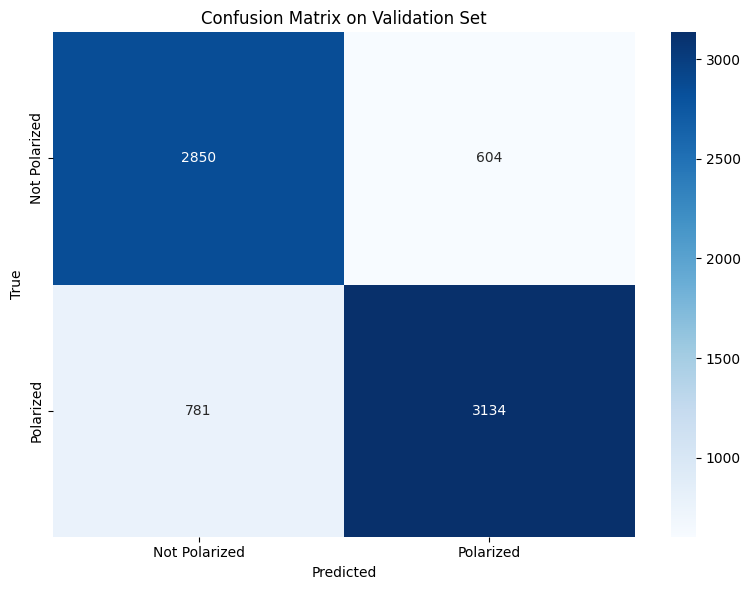

In [ ]:
# Detailed evaluation with confusion matrix and classification report
print("\nGenerating detailed predictions on validation set...")

# Get predictions
predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = val_data['polarization'].values

# Classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(
    true_labels,
    pred_labels,
    target_names=['Not Polarized (0)', 'Polarized (1)']
))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Not Polarized', 'Polarized'],
            yticklabels=['Not Polarized', 'Polarized'])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix on Validation Set')
plt.tight_layout()
plt.show()


Per-Language Performance on Validation Set:
language  samples  f1_macro  accuracy
     nep      202  0.910856  0.910891
     mya      282  0.881354  0.882979
     tel      272  0.867583  0.867647
     zho      409  0.866997  0.867971
     fas      337  0.816389  0.866469
     ori      226  0.807712  0.862832
     hin      258  0.806172  0.895349
     ben      349  0.800675  0.810888
     hau      359  0.784255  0.916435
     pan      162  0.782082  0.783951
     swa      703  0.776452  0.776671
     tur      245  0.759414  0.763265
     pol      265  0.754878  0.762264
     urd      354  0.752101  0.796610
     amh      355  0.746971  0.822535
     eng      309  0.743104  0.779935
     arb      313  0.730857  0.734824
     khm      673  0.719133  0.922734
     rus      351  0.713557  0.757835
     spa      293  0.685828  0.686007
     deu      299  0.673937  0.678930
     ita      353  0.605331  0.657224


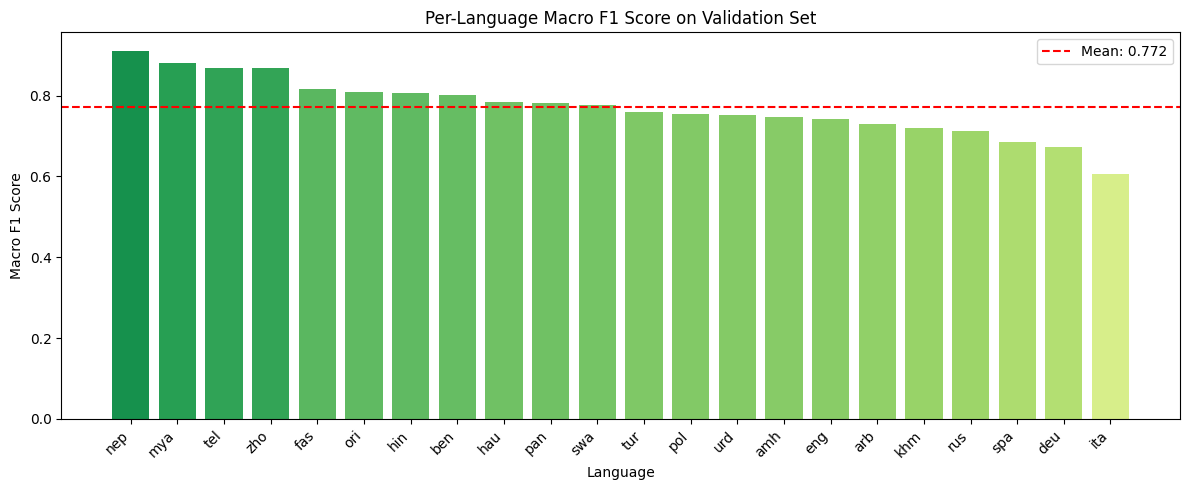

In [ ]:
# Per-language evaluation
print("\nPer-Language Performance on Validation Set:")

val_data_with_preds = val_data.copy()
val_data_with_preds['predicted'] = pred_labels

per_lang_results = []
for lang in val_data_with_preds['language'].unique():
    lang_data = val_data_with_preds[val_data_with_preds['language'] == lang]
    if len(lang_data) > 0:
        f1 = f1_score(lang_data['polarization'], lang_data['predicted'], average='macro')
        acc = accuracy_score(lang_data['polarization'], lang_data['predicted'])
        per_lang_results.append({
            'language': lang,
            'samples': len(lang_data),
            'f1_macro': f1,
            'accuracy': acc
        })

per_lang_df = pd.DataFrame(per_lang_results).sort_values('f1_macro', ascending=False)
print(per_lang_df.to_string(index=False))


# Visualize per-language performance
fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(per_lang_df['language'], per_lang_df['f1_macro'],
              color=plt.cm.RdYlGn(per_lang_df['f1_macro']))
ax.axhline(y=per_lang_df['f1_macro'].mean(), color='r', linestyle='--',
           label=f'Mean: {per_lang_df["f1_macro"].mean():.3f}')
ax.set_xlabel('Language')
ax.set_ylabel('Macro F1 Score')
ax.set_title('Per-Language Macro F1 Score on Validation Set')
ax.set_xticklabels(per_lang_df['language'], rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

## 7. Save Model

In [ ]:
# Save the LoRA adapter weights
model.save_pretrained(f"{config.OUTPUT_DIR}/model_finetuned")
tokenizer.save_pretrained(f"{config.OUTPUT_DIR}/model_finetuned")

print(f"\nModel saved to {config.OUTPUT_DIR}/model_finetuned")
print(f"\nFiles saved:")
for f in os.listdir(f"{config.OUTPUT_DIR}/model_finetuned"):
    print(f"  - {f}")


Model saved to /content/drive/MyDrive/LLM-Polar-SemEval/output_subtask1_xlmr-base/model_finetuned

Files saved:
  - config.json
  - model.safetensors
  - tokenizer_config.json
  - special_tokens_map.json
  - sentencepiece.bpe.model
  - tokenizer.json


In [ ]:
# Save training configuration
config_dict = {
    'model_name': config.MODEL_NAME,
    'max_length': config.MAX_LENGTH,
    'batch_size': config.BATCH_SIZE,
    'learning_rate': config.LEARNING_RATE,
    'num_epochs': config.NUM_EPOCHS,
    'validation_f1_macro': eval_results['eval_f1_macro'],
    'validation_accuracy': eval_results['eval_accuracy']
}

with open(f"{config.OUTPUT_DIR}/training_config.json", 'w') as f:
    json.dump(config_dict, f, indent=2)

print("Training configuration saved.")

Training configuration saved.


## 10. Summary

In [ ]:
print("TRAINING SUMMARY\n")
print(f"\nModel: {config.MODEL_NAME} + normal fine tuning")
print(f"LoRA: NOT USED")
print(f"Training Samples: {len(train_data)}")
print(f"Validation Samples: {len(val_data)}")
print(f"Dev Samples (for prediction): {len(dev_df)}")
print(f"\nValidation Results:")
print(f"  Macro F1: {eval_results['eval_f1_macro']:.4f}")
print(f"  Accuracy: {eval_results['eval_accuracy']:.4f}")

TRAINING SUMMARY


Model: xlm-roberta-base + normal fine tuning
LoRA: NOT USED
Training Samples: 66312
Validation Samples: 7369
Dev Samples (for prediction): 3687

Validation Results:
  Macro F1: 0.8118
  Accuracy: 0.8121


# ===========Subtask 2===========

### Cleaning

In [ ]:
objects_to_delete = ['model', 'trainer', 'tokenizer', 'optimizer', 'scheduler']

for obj_name in objects_to_delete:
    if obj_name in globals():
        del globals()[obj_name]

gc.collect()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

## 2. Data Loading and Preprocessing

In [ ]:
def clean_text_column(df: pd.DataFrame, col_name: str = 'text') -> pd.DataFrame:
    """
    Clean the text:
    1. Substitute newlines (\n) and tabs (\t) with spaces
    2. Convert multiple spaces in single one
    3. Removes spaces at the beginning/end of a string
    """

    df[col_name] = df[col_name].astype(str)

    # 1.
    df[col_name] = df[col_name].str.replace(r'[\n\r\t]', ' ', regex=True)

    # 2.
    df[col_name] = df[col_name].str.replace(r'\s+', ' ', regex=True)

    # 3.
    df[col_name] = df[col_name].str.strip()

    return df

def load_all_training_data(data_dir: str, languages: Optional[List[str]] = None) -> pd.DataFrame:
    train_dir = Path(data_dir) / "train"
    all_files = list(train_dir.glob("*.csv"))

    print(f"Find {len(all_files)} files in {train_dir}")

    dataframes = []
    stats = []

    for file_path in tqdm(all_files, desc="Loading data"):
        lang_code = file_path.stem

        if languages is not None and lang_code not in languages:
            continue

        try:
            df = pd.read_csv(
                file_path,
                quotechar='"',
                skipinitialspace=True,
                on_bad_lines='warn'
            )

            # Columns check
            required_cols = ['text'] + config.LABEL_COLUMNS
            missing_cols = [c for c in required_cols if c not in df.columns]

            if missing_cols:
                print(f"Warning: {file_path} missing {missing_cols}")
                continue

            df = df.dropna(subset=['text'])

            # Text cleaning
            df = clean_text_column(df, 'text')

            df['language'] = lang_code

            for col in config.LABEL_COLUMNS:
                df[col] = df[col].fillna(0).astype(int)

            # Statisitcs
            file_stats = {'language': lang_code, 'total_samples': len(df)}
            for col in config.LABEL_COLUMNS:
                count = df[col].sum()
                file_stats[col] = count
                file_stats[f'{col}_%'] = round((count / len(df) * 100), 1) if len(df) > 0 else 0

            stats.append(file_stats)
            dataframes.append(df)

        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    if not dataframes:
        print("No loaded data")
        return pd.DataFrame(), pd.DataFrame()

    combined_df = pd.concat(dataframes, ignore_index=True)
    stats_df = pd.DataFrame(stats)



    if not stats_df.empty:
        cols_order = ['language', 'total_samples'] + [c for c in stats_df.columns if c not in ['language', 'total_samples']]
        stats_df = stats_df[cols_order]

    print("Dataset statistics:\n")
    print(stats_df.to_string(index=False))
    print(f"\nTotal samples: {len(combined_df)}")

    return combined_df, stats_df

def load_dev_data(data_dir: str) -> pd.DataFrame:
    dev_dir = Path(data_dir) / "dev"
    all_files = list(dev_dir.glob("*.csv"))
    dataframes = []

    for file_path in tqdm(all_files, desc="Loading dev data"):
        lang_code = file_path.stem
        try:
            df = pd.read_csv(file_path, quotechar='"', skipinitialspace=True, on_bad_lines='warn')

            if 'text' not in df.columns:
                 continue

            df = clean_text_column(df, 'text')

            df['language'] = lang_code
            dataframes.append(df)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    if not dataframes:
        return pd.DataFrame()

    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"\nLoaded {len(combined_df)} dev samples")

    return combined_df

In [ ]:
# loading data
if config.USE_ALL_LANGUAGES:
    train_df, stats_df = load_all_training_data(config.DATA_DIR2)
else:
    train_df, stats_df = load_all_training_data(config.DATA_DIR2, config.SELECTED_LANGUAGES)

Find 22 files in /content/drive/MyDrive/LLM-Polar-SemEval/dev_phase/subtask2/train


Loading data:   0%|          | 0/22 [00:00<?, ?it/s]

Dataset statistics:

language  total_samples  political  political_%  racial/ethnic  racial/ethnic_%  religious  religious_%  gender/sexual  gender/sexual_%  other  other_%
     nep           2005        345         17.2            281             14.0        159          7.9            105              5.2    236     11.8
     pol           2391        875         36.6            215              9.0         87          3.6            110              4.6    155      6.5
     rus           3348        464         13.9            329              9.8        137          4.1            189              5.6     79      2.4
     tel           2366        511         21.6            402             17.0        212          9.0            314             13.3    561     23.7
     deu           3180       1295         40.7            589             18.5        354         11.1            187              5.9    439     13.8
     hin           2744       2023         73.7            333     

In [ ]:
def create_stratified_split(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    """
    Divid the dataframe using the multilabel stratification
    """
    df = df.reset_index(drop=True)

    X = df.index
    y = df[config.LABEL_COLUMNS].values

    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

    print("Avvio stratificazione iterativa")

    train_index, val_index = next(msss.split(X, y))

    train_df = df.iloc[train_index].copy()
    val_df = df.iloc[val_index].copy()


    # check
    print(f"Split Test Size: {test_size}")
    print(f"Train set: {len(train_df)} samples")
    print(f"Val set:   {len(val_df)} samples")

    print("\nComparison of percentages of positive cases by class:")
    print(f"{'Label':<20} | {'Total %':<12} | {'Train %':<12} | {'Val %':<12}")
    print("-" * 65)

    for col in config.LABEL_COLUMNS:
        orig_perc = (df[col].sum() / len(df)) * 100
        train_perc = (train_df[col].sum() / len(train_df)) * 100
        val_perc = (val_df[col].sum() / len(val_df)) * 100

        print(f"{col:<20} | {orig_perc:>10.2f}% | {train_perc:>10.2f}% | {val_perc:>10.2f}%")


    return train_df, val_df

In [ ]:
train_data, val_data = create_stratified_split(train_df, test_size=0.1)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

Avvio stratificazione iterativa
Split Test Size: 0.1
Train set: 66312 samples
Val set:   7369 samples

Comparison of percentages of positive cases by class:
Label                | Total %      | Train %      | Val %       
-----------------------------------------------------------------
political            |      27.39% |      27.39% |      27.40%
racial/ethnic        |      15.91% |      15.91% |      15.92%
religious            |      10.27% |      10.27% |      10.26%
gender/sexual        |       8.49% |       8.49% |       8.48%
other                |      18.60% |      18.60% |      18.59%
Training samples: 66312
Validation samples: 7369


## 3. Dataset Class and Tokenization

In [ ]:
class MultiLabelDataset(Dataset):
    """
    PyTorch Dataset for polarization classification.
    Handles tokenization and proper formatting for transformers.
    """

    def __init__(
        self,
        texts: List[str],
        labels: Optional[Union[List[List[int]], np.ndarray]],
        tokenizer,
        max_length: int = 256
    ):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.has_labels = labels is not None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False,
            return_tensors=None
        )

        item = {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask']
        }

        if self.has_labels:
            # expected shape: [num_labels] es: [1.0, 0.0, 1.0, 0.0, 0.0]
            labels_vector = self.labels[idx]
            if hasattr(labels_vector, 'tolist'):
                item['labels'] = [float(x) for x in labels_vector.tolist()]
            else:
                item['labels'] = [float(x) for x in labels_vector]

        return item

In [ ]:
print(f"Loading tokenizer: {config.MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

Loading tokenizer: xlm-roberta-base


In [ ]:
# Create datasets
train_dataset = MultiLabelDataset(
    texts=train_data['text'].tolist(),
    labels=train_data[config.LABEL_COLUMNS].values,
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

val_dataset = MultiLabelDataset(
    texts=val_data['text'].tolist(),
    labels=val_data[config.LABEL_COLUMNS].values,
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 66312
Validation dataset size: 7369


## 4. Model Setup

In [ ]:
if config.USE_CLASS_WEIGHTS:
    print("pos_weights computation...")

    pos_counts = train_df[config.LABEL_COLUMNS].sum().values
    total_samples = len(train_df)
    neg_counts = total_samples - pos_counts

    pos_weights_calc = neg_counts / np.maximum(pos_counts, 1)

    # To tensor
    pos_weights = torch.tensor(pos_weights_calc, dtype=torch.float32).to(config.DEVICE)
    print(f"Pos weights:\n{dict(zip(config.LABEL_COLUMNS, pos_weights_calc.round(3)))}")
else:
    pos_weights = None

pos_weights computation...
Pos weights:
{'political': np.float64(2.65), 'racial/ethnic': np.float64(5.285), 'religious': np.float64(8.741), 'gender/sexual': np.float64(10.785), 'other': np.float64(4.377)}


In [ ]:
# Loading the model
print(f"Loading model: {config.MODEL_NAME}")

# Mapping
id2label = {idx: label for idx, label in enumerate(config.LABEL_COLUMNS)}
label2id = {label: idx for idx, label in enumerate(config.LABEL_COLUMNS)}

model = AutoModelForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=len(config.LABEL_COLUMNS),
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)

print(f"\nModel parameters (base): {model.num_parameters():,}")

Loading model: xlm-roberta-base


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model parameters (base): 278,047,493


## 5. Training Setup

In [ ]:
def compute_metrics(eval_pred):
    """
    Metrics computation for Multi-Label Classification
    Use a threshold (0.5) instead of argmax
    """
    logits, labels = eval_pred

    # Converts Logits in Probabilities using Sigmoide
    #    (Formula: 1 / (1 + e^-x))
    probs = 1 / (1 + np.exp(-logits))
    predictions = (probs > 0.5).astype(int)


    f1_micro = f1_score(labels, predictions, average='micro')
    f1_macro = f1_score(labels, predictions, average='macro')
    precision_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(labels, predictions, average='macro', zero_division=0)

    accuracy = accuracy_score(labels, predictions)

    results = {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'accuracy': accuracy,
    }


    # Metrics per class
    label_names = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

    f1_per_class = f1_score(labels, predictions, average=None, zero_division=0)

    for i, label_name in enumerate(label_names):
        results[f'f1_{label_name}'] = f1_per_class[i]

    # ROC-AUC
    try:
        roc_auc = roc_auc_score(labels, probs, average='macro')
        results['roc_auc'] = roc_auc
    except ValueError:
        results['roc_auc'] = 0.0

    return results

In [ ]:
class MultilabelTrainer(Trainer):
    """
        Customised trainer for weighted loss in a multi-label context
    """
    def __init__(self, pos_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weights = pos_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")

        outputs = model(**inputs)
        logits = outputs.get("logits")

        if self.pos_weights is not None:
            weights = self.pos_weights.to(logits.device)
            loss_fct = nn.BCEWithLogitsLoss(pos_weight=weights)
        else:
            loss_fct = nn.BCEWithLogitsLoss()

        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
# Create output directory
os.makedirs(config.OUTPUT_DIR2, exist_ok=True)

# Training arguments
training_args = TrainingArguments(
    output_dir=config.OUTPUT_DIR2,

    # Training hyperparameters
    num_train_epochs=config.NUM_EPOCHS,
    learning_rate=config.LEARNING_RATE,
    per_device_train_batch_size=config.BATCH_SIZE,
    per_device_eval_batch_size=config.EVAL_BATCH_SIZE,
    gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,

    # Optimization
    warmup_ratio=config.WARMUP_RATIO,
    weight_decay=config.WEIGHT_DECAY,
    optim="adamw_torch",
    lr_scheduler_type="cosine",

    # Evaluation
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    # Logging
    logging_dir=f"{config.OUTPUT_DIR2}/logs",
    logging_steps=100,
    report_to="none",  # Set to "wandb" if using Weights & Biases

    # Efficiency
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,

    # Saving
    save_total_limit=1,

    # Reproducibility
    seed=config.SEED,
    data_seed=config.SEED,
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding=True,
    return_tensors="pt"
)

print("Training configuration:")
print(f"  Epochs: {config.NUM_EPOCHS}")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Effective batch size: {config.BATCH_SIZE * config.GRADIENT_ACCUMULATION_STEPS}")
print(f"  Learning rate: {config.LEARNING_RATE}")
print(f"  Total training steps: {len(train_dataset) // (config.BATCH_SIZE * config.GRADIENT_ACCUMULATION_STEPS) * config.NUM_EPOCHS}")

Training configuration:
  Epochs: 7
  Batch size: 8
  Effective batch size: 32
  Learning rate: 2e-05
  Total training steps: 14504


In [ ]:
# Create trainer
trainer = MultilabelTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    pos_weights=pos_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

## 6. Training

In [ ]:
# Clear GPU memory before training
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Starting training...")
print("="*60)

# Train the model
train_result = trainer.train()

print("="*60)
print("Training completed!")

Starting training...


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Macro,Recall Macro,Accuracy,F1 Political,F1 Racial/ethnic,F1 Religious,F1 Gender/sexual,F1 Other,Roc Auc
1,0.712800,0.635297,0.618633,0.600644,0.471807,0.844499,0.491926,0.711851,0.574493,0.610701,0.496539,0.609635,0.909336
2,0.599800,0.586153,0.659295,0.644997,0.523980,0.849392,0.557335,0.755010,0.611312,0.669439,0.566757,0.622466,0.926551
3,0.516300,0.570639,0.662743,0.645118,0.519446,0.858169,0.560592,0.751309,0.631083,0.625592,0.582180,0.635425,0.931039
4,0.457200,0.640513,0.669643,0.655404,0.546452,0.825401,0.592211,0.759769,0.627017,0.652374,0.606870,0.630992,0.927628
5,0.357700,0.709095,0.680616,0.663531,0.564719,0.809104,0.610666,0.766158,0.645875,0.662664,0.592000,0.650957,0.923411
6,0.332900,0.745802,0.684180,0.666040,0.574792,0.796231,0.623422,0.768251,0.647907,0.653369,0.598366,0.662309,0.922952
7,0.298600,0.786597,0.688939,0.671969,0.590697,0.781940,0.636857,0.766773,0.649549,0.669309,0.607545,0.666667,0.920995


Training completed!


In [ ]:
# Print training metrics
print("\nTraining Metrics:")
print(f"  Total training time: {train_result.metrics['train_runtime']:.2f}s")
print(f"  Samples/second: {train_result.metrics['train_samples_per_second']:.2f}")
print(f"  Final training loss: {train_result.metrics['train_loss']:.4f}")


Training Metrics:
  Total training time: 4912.51s
  Samples/second: 94.49
  Final training loss: 0.4866


In [ ]:
# Evaluate on validation set
print("\nEvaluating on validation set...")
eval_results = trainer.evaluate()

print("\nValidation Results:\n")
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")


Evaluating on validation set...



Validation Results:

  eval_loss: 0.7866
  eval_f1_micro: 0.6889
  eval_f1_macro: 0.6720
  eval_precision_macro: 0.5907
  eval_recall_macro: 0.7819
  eval_accuracy: 0.6369
  eval_f1_political: 0.7668
  eval_f1_racial/ethnic: 0.6495
  eval_f1_religious: 0.6693
  eval_f1_gender/sexual: 0.6075
  eval_f1_other: 0.6667
  eval_roc_auc: 0.9210
  eval_runtime: 7.8835
  eval_samples_per_second: 934.7340
  eval_steps_per_second: 58.4760
  epoch: 7.0000


In [ ]:
def evaluate_f1_by_language(trainer, val_dataset, val_df):
    print("Generazione predizioni per analisi per lingua...")

    # Logits
    output = trainer.predict(val_dataset)
    logits = output.predictions

    # Predictions
    probs = 1 / (1 + np.exp(-logits))
    predictions = (probs > 0.5).astype(int)

    label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
    y_true = val_df[label_cols].values
    languages = val_df['language'].unique()

    results = []

    for lang in languages:
        mask = (val_df['language'] == lang).values

        lang_preds = predictions[mask]
        lang_true = y_true[mask]

        if len(lang_preds) > 0:
            f1 = f1_score(lang_true, lang_preds, average='macro', zero_division=0)
            results.append({'language': lang, 'f1_macro': f1, 'count': len(lang_preds)})


    res_df = pd.DataFrame(results).sort_values('f1_macro', ascending=False)

    print("\nF1 MACRO per language\n")
    print(res_df.to_string(index=False))

    plt.figure(figsize=(12, 6))

    norm = plt.Normalize(res_df['f1_macro'].min(), res_df['f1_macro'].max())
    colors = plt.cm.RdYlGn(norm(res_df['f1_macro'].values))

    bars = plt.bar(res_df['language'], res_df['f1_macro'], color=colors, edgecolor='black', alpha=0.8)

    avg_f1 = res_df['f1_macro'].mean()
    plt.axhline(avg_f1, color='blue', linestyle='--', label=f'Media: {avg_f1:.3f}')

    plt.title('Per Language performance (F1 Macro)', fontsize=14)
    plt.ylabel('F1 Score')
    plt.xlabel('Language')
    plt.ylim(0, 1.05)
    plt.legend()

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f"{config.OUTPUT_DIR2}/f1_per_language.png", dpi=600)
    plt.show()

Generazione predizioni per analisi per lingua...



F1 MACRO per language

language  f1_macro  count
     nep  0.778593    194
     hin  0.769156    268
     zho  0.731735    412
     urd  0.725831    376
     mya  0.641594    258
     fas  0.636704    316
     khm  0.635136    705
     spa  0.616128    322
     arb  0.613850    372
     pol  0.587619    213
     ori  0.575372    237
     tur  0.543441    220
     deu  0.523854    347
     rus  0.515226    381
     amh  0.507386    320
     hau  0.488084    363
     eng  0.458964    337
     swa  0.419425    681
     tel  0.419106    243
     ita  0.392644    327
     pan  0.385429    169
     ben  0.247070    308


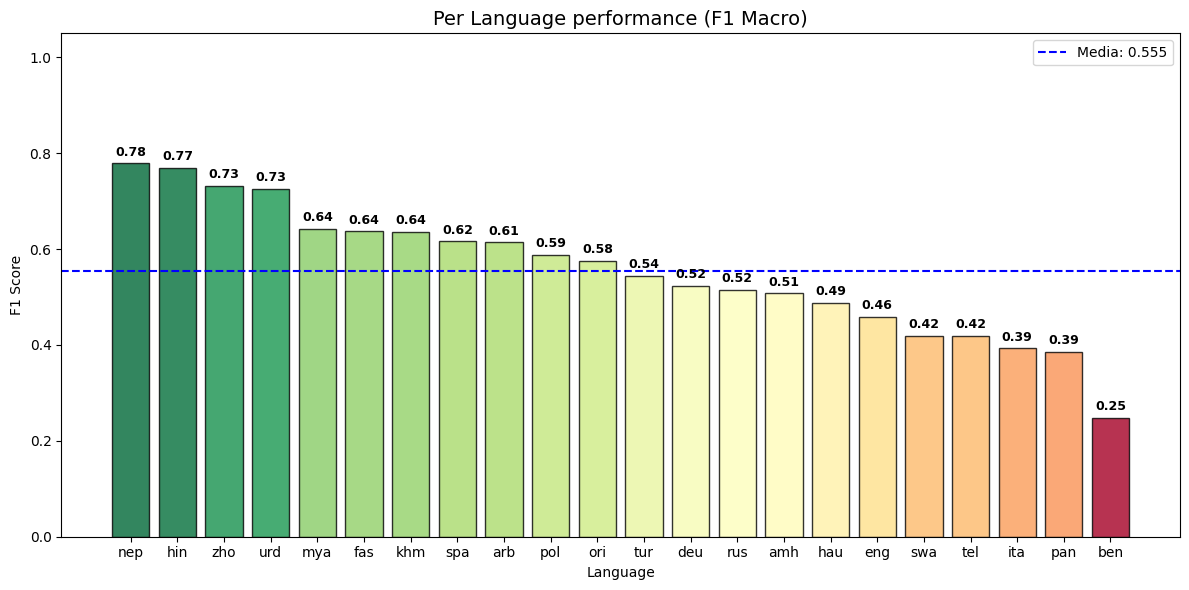

In [ ]:
evaluate_f1_by_language(trainer, val_dataset, val_data)

In [ ]:
# Save the  weights
model.save_pretrained(f"{config.OUTPUT_DIR2}/model_finetuned")
tokenizer.save_pretrained(f"{config.OUTPUT_DIR2}/model_finetuned")

print(f"\nModel saved to {config.OUTPUT_DIR2}/model_finetuned")
print(f"\nFiles saved:")
for f in os.listdir(f"{config.OUTPUT_DIR2}/model_finetuned"):
    print(f"  - {f}")


Model saved to /content/drive/MyDrive/LLM-Polar-SemEval/output_subtask2_xlmr-base/model_finetuned

Files saved:
  - config.json
  - model.safetensors
  - tokenizer_config.json
  - special_tokens_map.json
  - sentencepiece.bpe.model
  - tokenizer.json


In [ ]:
# Save training configuration
config_dict = {
    'model_name': config.MODEL_NAME,
    'max_length': config.MAX_LENGTH,
    'batch_size': config.BATCH_SIZE,
    'learning_rate': config.LEARNING_RATE,
    'num_epochs': config.NUM_EPOCHS,
    'validation_f1_macro': eval_results['eval_f1_macro'],
    'validation_accuracy': eval_results['eval_accuracy']
}

with open(f"{config.OUTPUT_DIR2}/training_config.json", 'w') as f:
    json.dump(config_dict, f, indent=2)

print("Training configuration saved.")

Training configuration saved.


## Summary

In [ ]:
print("TRAINING SUMMARY\n")
print(f"\nModel: {config.MODEL_NAME} + normal fine tuning")
print(f"LoRA: NOT USED")
print(f"Training Samples: {len(train_data)}")
print(f"Validation Samples: {len(val_data)}")
print(f"\nValidation Results:")
print(f"  Macro F1: {eval_results['eval_f1_macro']:.4f}")
print(f"  Accuracy: {eval_results['eval_accuracy']:.4f}")

TRAINING SUMMARY


Model: xlm-roberta-base + normal fine tuning
LoRA: NOT USED
Training Samples: 66312
Validation Samples: 7369

Validation Results:
  Macro F1: 0.6720
  Accuracy: 0.6369
